# Reprojecting and Formatting PACE OCI Data

**Authors:** Skye Caplan (NASA, SSAI)

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/

## Summary

This notebook will use `rioxarray` to reproject PACE OCI data from the instrument swath into a projected coordinate system and save the file as a GeoTIFF (.tif), a common data format used in GIS applications.

## Learning Objectives

At the end of this notebook you will know:

- Open PACE OCI surface reflectance and vegetation index products
- Reproject those data into defined coordinate reference systems
- Export those reprojected data as GeoTIFFs

## Contents

1. [Setup](#1.-Setup)
2. [Reprojecting Level 2 PACE Data](#2.-Reprojecting-L2-PACE-Data)
3. [Exporting to GeoTIFF](#3.-Exporting-to-GeoTIFF)
4. [About Converting Level 3 Data to GeoTIFF](#4.-A-Note-Converting-About-Level-3-Data)

## 1. Setup

Begin by importing all of the packages used in this notebook. Please ensure your environment has the most recent versions of `rioxarray` and `rasterio`, as the functionality allowing us to correctly convert PACE Level 2 (L2) files to GeoTIFF is relatively new.

In [1]:
from pathlib import Path

import earthaccess
import rasterio
import xarray as xr
import numpy as np
import rioxarray as rio
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cf_xarray  # noqa: F401
from xarray.backends.api import open_datatree

The goal of this tutorial is to reproject and convert L2 PACE data between formats, but L2 PACE data comes in many forms. We'll cover two examples here - one with 3-dimensional surface reflectance (SFREFL) data, and one with 2-dimensional vegetation index (VI) data - to illustrate how these datasets need to be handled.

The following cells use `earthaccess` to set and persist your Earthdata login credentials, then search for and download the relevant datasets for a scene covering eastern North America. 

In [2]:
auth = earthaccess.login(persist=True)

results = earthaccess.search_data(
    short_name=["PACE_OCI_L2_SFREFL","PACE_OCI_L2_LANDVI"],
    granule_name="*20240701T175112*",
)
results[0]

Collection: {'ShortName': 'PACE_OCI_L2_LANDVI', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 48.76606, 'Longitude': -65.20255}, {'Latitude': 42.73293, 'Longitude': -99.1249}, {'Latitude': 25.62384, 'Longitude': -90.6707}, {'Latitude': 30.94837, 'Longitude': -63.88272}, {'Latitude': 48.76606, 'Longitude': -65.20255}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-07-01T17:51:12Z', 'EndingDateTime': '2024-07-01T17:56:12Z'}}
Size(MB): 51.86107540130615
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701T175112.L2.LANDVI.V3_0.nc']

In [3]:
results[1]

Collection: {'Version': '3.0', 'ShortName': 'PACE_OCI_L2_SFREFL'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Latitude': 48.76606, 'Longitude': -65.20255}, {'Latitude': 42.73293, 'Longitude': -99.1249}, {'Latitude': 25.62384, 'Longitude': -90.6707}, {'Latitude': 30.94837, 'Longitude': -63.88272}, {'Latitude': 48.76606, 'Longitude': -65.20255}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-07-01T17:51:12Z', 'EndingDateTime': '2024-07-01T17:56:12Z'}}
Size(MB): 750.2740449905396
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701T175112.L2.SFREFL.V3_0.nc']

In [4]:
paths = earthaccess.download(results, local_path="data")

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

[back to top](#Contents)

## 2. Reprojecting L2 PACE Data
### 2.1. 2D Variables - Vegetation Indices

All of PACE's L2 data are still in the instrument swath - in other words, they are not projected to any sort of regular grid, which makes comparing between satellites, or even between two PACE granules in the same location, difficult. However, each pixel is geolocated (i.e., has an associated latitude and longitude), meaning we can reproject our data onto a grid to make working with it more intuitive. 

As mentioned above, we're working with two data products in this tutorial. We'll open both as `xarray` datatrees and display their different dimensional architecture:

In [5]:
vi_path, sr_path = paths[0], paths[1]

sr_dt = open_datatree(sr_path)
vi_dt = open_datatree(vi_path)

print("Surface reflectance dimensions: ", sr_dt.geophysical_data.rhos.dims)
print("Vegetation index dimensions: ", vi_dt.geophysical_data.cire.dims)

Surface reflectance dimensions:  ('number_of_lines', 'pixels_per_line', 'wavelength_3d')
Vegetation index dimensions:  ('number_of_lines', 'pixels_per_line')


As we can see, the dimensions between the variables in both datasets differ. The surface reflectances contained in the `rhos` variable have 3 dimensions corresponding to (rows, columns, wavelengths), while each VI variable (e.g., `ndvi` or `cire`) is a 2D variable with (row, column) dimensions. 

If we plot one of these variables, we'll see that they aren't on any sort of regular spatial grid, and will instead be plotted by their row (`number_of_lines`) and column (`pixels_per_line`) indices as any non-geospatial array would be.

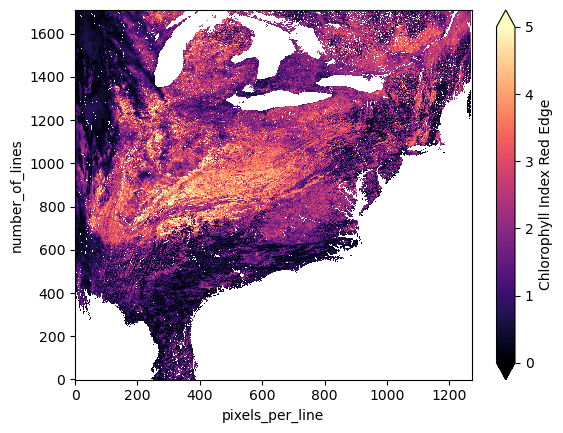

In [6]:
vi_dt.geophysical_data.cire.plot(cmap="magma", vmin=0, vmax=5)
plt.show()

This is fine for a quick look into the data, but any analysis would be better served with a mapped dataset. Let's start with VIs to illustrate the projection process. We'll take the whole `geophysical_data` group as the source dataset for reprojection since each VI is contained in this group as a separate variable in the dataset.

The basic steps for reprojection are:
  1. Mask for any quality issues or obscured pixels
  2. Set the coordinates to the latitudes and longitudes from the `navigation_data` group
  3. Assign the spatial dimensions as the columns (or the x coordinate, `pixels_per_line`) and rows (or the y coordinate, `number_of_lines`)
  4. Assign the source Coordinate Reference System (CRS). Since we are working with unprojected PACE lat/lons based on the WGS84 datum, we'll use EPSG 4326 as our source CRS.
  5. Use `rio.reproject` to project our source dataset

We can see in the plot above that the VI datasets come masked for water, but we should also mask out any cloudy pixels for a clean dataset as well. If we print out the `geophysical_data` group of either of our datasets, there will be a variable called `l2_flags` at the bottom of the list, in which the quality flag information is stored:

In [7]:
vi_src = vi_dt["geophysical_data"].to_dataset()
vi_src

<xarray.Dataset> Size: 96MB
Dimensions:   (number_of_lines: 1710, pixels_per_line: 1272)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    ndvi      (number_of_lines, pixels_per_line) float32 9MB ...
    evi       (number_of_lines, pixels_per_line) float32 9MB ...
    ndwi      (number_of_lines, pixels_per_line) float32 9MB ...
    ndii      (number_of_lines, pixels_per_line) float32 9MB ...
    cci       (number_of_lines, pixels_per_line) float32 9MB ...
    ndsi      (number_of_lines, pixels_per_line) float32 9MB ...
    pri       (number_of_lines, pixels_per_line) float32 9MB ...
    cire      (number_of_lines, pixels_per_line) float32 9MB ...
    car       (number_of_lines, pixels_per_line) float32 9MB ...
    mari      (number_of_lines, pixels_per_line) float32 9MB ...
    l2_flags  (number_of_lines, pixels_per_line) int32 9MB ...

The `cf_xarray` package allows us to access and use `l2_flags` to mask our data. There are multiple flags we could apply, but here we will only mask for `CLDICE`, the flag for clouds. More information on each flag can be found at [this link](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/).

In [8]:
if vi_src.l2_flags.cf.is_flag_variable:
    cloud_mask = ~(vi_src.l2_flags.cf=="CLDICE")
    vi_src = vi_src.where(cloud_mask)

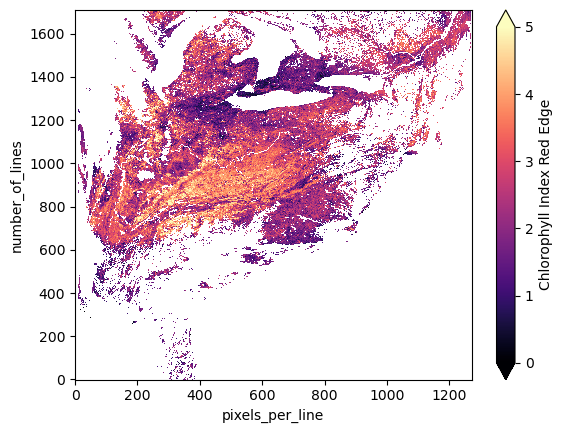

In [9]:
vi_src.cire.plot(cmap="magma", vmin=0, vmax=5)
plt.show()

Now that our dataset represents only (relatively) clear-sky pixels, we can move on to steps 2 - 4 of the reprojection, that is, assigning coordinates, spatial reference, and a CRS to the data. Note that this has to be done after the masking due to issues in the reprojection step if the order if flipped. 

In [10]:
vi_src.coords["longitude"] = vi_dt["navigation_data"]["longitude"]
vi_src.coords["latitude"] = vi_dt["navigation_data"]["latitude"]

vi_src = vi_src.rio.set_spatial_dims("pixels_per_line", "number_of_lines").rio.write_crs("epsg:4326")
vi_src

<xarray.Dataset> Size: 122MB
Dimensions:      (number_of_lines: 1710, pixels_per_line: 1272)
Coordinates:
    longitude    (number_of_lines, pixels_per_line) float32 9MB ...
    latitude     (number_of_lines, pixels_per_line) float32 9MB ...
    spatial_ref  int64 8B 0
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    ndvi         (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    evi          (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    ndwi         (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    ndii         (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    cci          (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    ndsi         (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    pri          (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    cire         (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    car          (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    mari         (number_of_lines, pixels_per_line) float32 9MB nan nan ... nan
    l2_flags     (number_of_lines, pixels_per_line) float64 17MB nan ... 1.07...

If we compare `vi_src` before and after these steps, it looks like nothing much has changed. However, you can see that under `Coordinates` we now have `longitude` and `latitude`, as well as the `spatial_ref` variable, which contains the spatial reference information necessary to reproject the data.

In the next cell, we create a destination dataset, `vi_dst`, the projected version of the source dataset. The key parameter in this step is the `src_geoloc_array`, which is how we're able to feed the function our coordinate arrays and get out a projected dataset. In this example, we project into EPSG 4326, but any defined CRS can be used for the `dst_crs`. 

In [11]:
vi_dst = vi_src.rio.reproject(
    dst_crs=vi_src.rio.crs,
    src_geoloc_array=(
        vi_src.coords["longitude"],
        vi_src.coords["latitude"],
    ),
)

We can plot the data with a basemap to see that it was correctly georeferenced and reprojected.

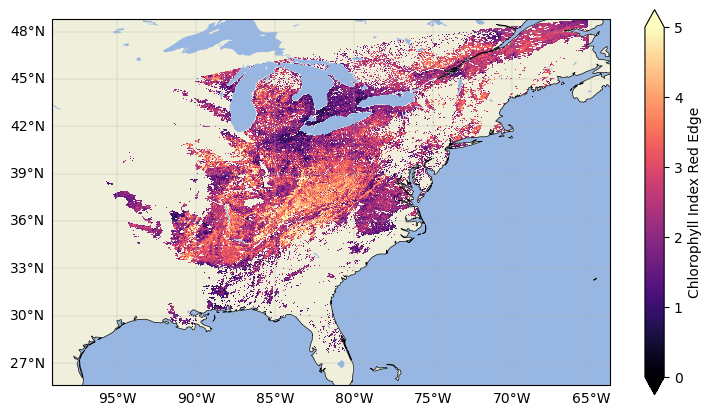

In [12]:
fig, ax = plt.subplots(
    1, 1, figsize=(9, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
ax.coastlines(linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAKES, edgecolor="w", linewidth=0.01)
vi_dst.cire.plot(cmap="magma", vmin=0, vmax=5)
plt.title("")
plt.show()

The VI data is now masked and reprojected! Now let's start with our 3D surface reflectances.

### 2.2. 3D Variables - Surface Reflectance 

Typically, you'd be able to repeat the process we completed for the VIs above for most 3D data, and if you tried it with PACE surface reflectances, it would work. However, in addition to reprojecting PACE data, another goal of this tutorial is to export the data into GeoTIFF format for use in a GIS software. Many of these programs, and specifically the popular [QGIS](https://qgis.org/) software, require that the data dimension order use the rule (Z, Y, X), where Y and X are positional coordinates like latitude and longitude and Z is a third dimension like wavelength. 

Recalling from above, the surface reflectance variable `rhos` has dimensions (rows, columns, wavelengths) - in other words, (Y, X, Z). Without resolving this issue, trying to load PACE surface reflectance data in QGIS will result in what looks like nonsensical lines and squares instead of a rich reflectance data cube.

To put PACE reflectances in the correct dimensional order, all we have to do is transpose the data so that the wavelength dimension, `wavelength_3d`, is first. 

Before this, we include code that renames the wavelength_3d variable to the center wavelength of each band. This makes it easier to select bands based on wavelength values versus just 1-122 numerical ordering. 

In [13]:
sr_dt['geophysical_data'] = sr_dt['geophysical_data'].to_dataset().assign_coords(sr_dt["sensor_band_parameters"].coords)
sr_dt["geophysical_data"]

<xarray.DataTree 'geophysical_data'>
Group: /geophysical_data
    Dimensions:        (number_of_lines: 1710, pixels_per_line: 1272,
                        wavelength_3d: 122)
    Coordinates:
      * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    Dimensions without coordinates: number_of_lines, pixels_per_line
    Data variables:
        rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
        l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...

In [15]:
sr_src = sr_dt["geophysical_data"]["rhos"]
sr_src = sr_src.transpose("wavelength_3d", ...)

sr_src

<xarray.DataArray 'rhos' (wavelength_3d: 122, number_of_lines: 1710,
                          pixels_per_line: 1272)> Size: 1GB
[265364640 values with dtype=float32]
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
Dimensions without coordinates: number_of_lines, pixels_per_line
Attributes:
    long_name:  Surface reflectance
    valid_min:  -0.05
    valid_max:  1.0

The `rhos` variable is now in dimension order (Z, Y, X), which will allow QGIS and other software with the same requirement to properly handle the surface reflectance data. Note that we are setting `sr_src` to include only `rhos` and not `l2_flags`. We separate these variables to allow for exporting in Section 3, as the `rio.to_raster` method cannot handle two dataarrays with different dimensions (i.e., 3D for `rhos` and 2D for `l2_flags`). That means if you want your surface reflectance data masked with any of the flags we explained above, you'll have to do it before the step above. 

We can now complete the rest of the steps above to reproject the data.

In [16]:
sr_src.coords["longitude"] = sr_dt["navigation_data"]["longitude"]
sr_src.coords["latitude"] = sr_dt["navigation_data"]["latitude"]

sr_src = sr_src.rio.set_spatial_dims("pixels_per_line", "number_of_lines").rio.write_crs("epsg:4326")

sr_dst = sr_src.rio.reproject(
    dst_crs=sr_src.rio.crs,
    src_geoloc_array=(
        sr_src.coords["longitude"],
        sr_src.coords["latitude"],
    ),
    nodata=np.nan
)

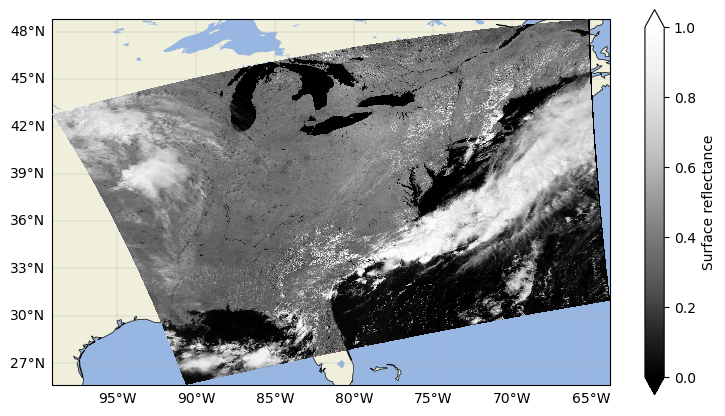

In [17]:
fig, ax = plt.subplots(
    1, 1, figsize=(9, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25)
ax.coastlines(linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
ax.add_feature(cartopy.feature.LAKES, edgecolor="w", linewidth=0.01)
sr_dst.sel({'wavelength_3d':860}).plot(cmap="Greys_r", vmin=0, vmax=1, zorder=101)
plt.title("")
plt.show()

## 3. Exporting to GeoTIFF

Now that we have two georeferenced, projected datasets of surface reflectances and VIs, you can export them to your preferred format. Here, we export to GeoTIFF using the "GTiff" driver and applicable profile options. 

We do this by creating a profile from the destination datasets (`sr_dst` or `vi_dst`) and using the `rio.to_raster()` method. Each of the profile options is necessary for the format conversion, but can be changed to user preference as necessary. For example, if you prefer a different `nodata` value or have a specific Affine `transform` for the dataset that would better serve your needs, substitute those values in the dictionaries below.

In [18]:
sr_dst_name = Path(sr_path).with_suffix(".tif") 
profile = {
    "driver": "GTiff",
    "width": sr_dst.shape[2],
    "height": sr_dst.shape[1],
    "count": sr_dst.shape[0],
    "crs": sr_dst.rio.crs,
    "dtype": sr_dst.dtype,
    "transform": sr_dst.rio.transform(),
    "compress": "lzw",
    "nodata": np.nan,
    "tiled": True                           
    }
sr_dst.rio.to_raster(sr_dst_name, **profile)

vi_dst_name = Path(vi_path).with_suffix(".tif")
profile = {
    "driver": "GTiff",
    "width": vi_dst.cire.shape[1],
    "height": vi_dst.cire.shape[0],
    "count": 11,
    "crs": vi_dst.rio.crs,
    "dtype": vi_dst.cire.dtype,
    "transform": vi_dst.rio.transform(),
    "compress": "lzw",
    "nodata": np.nan,
    "tiled": True                           
    }
vi_dst.rio.to_raster(vi_dst_name, **profile)

The files should be successfully converted, and able to be analyzed properly in QGIS and other software! To make a nice quick true colour image in your program of choice, you can set R = 655 nm (band 60), G = 555 nm (band 42), and B = 470 nm (band 25). 

To do the format conversion and reprojection in one step, please see the function below:

In [19]:
def nc_to_gtiff(fpath):
    """
    Convert a PACE SFREFL or LANDVI NetCDF file to GeoTIFF format
    Masks LANDVI dataset for clouds automatically
    Args:
        fpath - Path to NetCDF file to convert
    """
    dt = xr.open_datatree(fpath)
    
    if "SFREFL" in fpath:
        src = dt["geophysical_data"]["rhos"].transpose("wavelength_3d", ...)
    elif "LANDVI" in fpath:
        src = dt["geophysical_data"].to_dataset()
        if src.l2_flags.cf.is_flag_variable:
            cloud_mask = ~(src.l2_flags.cf =="CLDICE")
            src = src.where(cloud_mask)
    else:
        print("File is neither the SFREFL nor LANDVI PACE suite, you'll have to adapt these methods yourself!")
        return
        
    src.coords["longitude"] = dt["navigation_data"]["longitude"]
    src.coords["latitude"] = dt["navigation_data"]["latitude"]
    src = (
        src.rio.set_spatial_dims("pixels_per_line", "number_of_lines").rio.write_crs("epsg:4326")
    )

    dst = src.rio.reproject(
        dst_crs=src.rio.crs, 
        src_geoloc_array=(
            src.coords["longitude"], 
            src.coords["latitude"]),
        )

    if "SFREFL" in fpath:
        width, height, count = dst.shape[2], dst.shape[1], dst.shape[0]
        dtype = dst.dtype
    elif "LANDVI" in fpath:
        width, height, count = dst.cire.shape[1], dst.cire.shape[0], 11
        dtype = dst.cire.dtype
        
    dst_name = Path(fpath).with_suffix(".tif")
    profile = {
        "driver": "GTiff", 
        "width": width,
        "height": height,
        "count": count,
        "crs": dst.rio.crs,
        "dtype": dtype,
        "transform": dst.rio.transform(),
        "compress": "lzw",
        "nodata": np.nan,
        "tiled": True
    }
    
    dst.rio.to_raster(dst_name, **profile)

In [20]:
nc_to_gtiff(vi_path)

## 4. A Note About Converting Level 3 Data to GeoTIFF

Level 3 PACE data is already mapped to a Plate Carrée projection - in other words, unless you want the data in another projection, you don't need to reproject as we did for the Level 2 data above. In order to convert these files from NetCDF to GeoTIFF, all you need is to transpose the datasets as necessary and assign a CRS.

First, let's download a Level-3 Global Mapped Surface Reflectance file.

In [21]:
results = earthaccess.search_data(
    short_name = 'PACE_OCI_L3M_LANDVI',
    granule_name = 'PACE_OCI.20240601_20240630.L3m.MO.LANDVI.V3_0.0p1deg.nc')

paths = earthaccess.download(results, local_path="data")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
if "SFREFL" in paths[0]:
    ds = xr.open_dataset(paths[0]).rhos.transpose("wavelength", ...)
elif "LANDVI" in paths[0]:
    ds = xr.open_dataset(paths[0]).drop_vars("palette")
    
ds = ds.rio.write_crs("epsg:4326")
ds.rio.to_raster(Path(paths[0]).with_suffix(".tif"))

[back to top](#Contents)

<div class="alert alert-info" role="alert">

You have completed the notebook on reprojecting and format conversion of PACE OCI L2 data. We suggest looking at the notebook on "Machine Learning with Satellite Data" to explore some more advanced analysis methods.

</div>